In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date
from itertools import product
from pprint import pprint

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from scipy.special import expit

from vaxflux.covariates import (
    CovariateCategories,
    GaussianCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticCurve
from vaxflux.data import sample_dataset
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
true_epsilon = 0.0005
conf_interval = 0.95
conf_lower = (1.0 - conf_interval) / 2.0
conf_higher = 1.0 - conf_lower
tune = 12000
draws = 1000
chains = 2
seed = 123

In [3]:
logistic_curve = LogisticCurve()
logistic_curve

In [4]:
logistic_curve.parameters

('m', 'r', 's')

In [5]:
range_days = 6
season_ranges = [
    SeasonRange(
        season="2022/23",
        start_date=date(2022, 9, 5),
        end_date=date(2023, 1, 29),
    ),
    SeasonRange(
        season="2023/24",
        start_date=date(2023, 9, 4),
        end_date=date(2024, 1, 28),
    ),
    SeasonRange(
        season="2024/25",
        start_date=date(2024, 9, 2),
        end_date=date(2025, 1, 26),
    ),
]
date_ranges = daily_date_ranges(season_ranges, range_days=range_days)

In [6]:
sex_cov = CovariateCategories(covariate="sex", categories=("female", "male"))
age_cov = CovariateCategories(
    covariate="age",
    categories=("adult", "senior", "elderly"),
)

In [7]:
params = []

params_grid = {
    "2022/23": {
        "m": -0.5,
        "r": -3.2,
        "s": 40.0,
        "male": {
            "m": -0.05,
        },
        "senior": {
            "m": 1.0,
        },
        "elderly": {
            "m": 1.8,
        },
    },
    "2023/24": {
        "m": -0.6,
        "r": -3.1,
        "s": 42.5,
        "male": {
            "m": -0.06,
        },
        "senior": {
            "m": 1.05,
        },
        "elderly": {
            "m": 1.78,
        },
    },
    "2024/25": {
        "m": -0.4,
        "r": -3.3,
        "s": 41.0,
        "male": {
            "m": -0.04,
        },
        "senior": {
            "m": 1.03,
        },
        "elderly": {
            "m": 1.81,
        },
    },
}

for curve_param in logistic_curve.parameters:
    for season_range in season_ranges:
        for sex_category in sex_cov.categories:
            for age_category in age_cov.categories:
                season_params = params_grid[season_range.season]
                param_value = (
                    season_params[curve_param]
                    + season_params.get(sex_category, {}).get(curve_param, 0)
                    + season_params.get(age_category, {}).get(curve_param, 0)
                )
                params.append(
                    (
                        curve_param,
                        season_range.season,
                        sex_category,
                        age_category,
                        param_value,
                    ),
                )

pprint(params)  # noqa: T203

[('m', '2022/23', 'female', 'adult', -0.5),
 ('m', '2022/23', 'female', 'senior', 0.5),
 ('m', '2022/23', 'female', 'elderly', 1.3),
 ('m', '2022/23', 'male', 'adult', -0.55),
 ('m', '2022/23', 'male', 'senior', 0.44999999999999996),
 ('m', '2022/23', 'male', 'elderly', 1.25),
 ('m', '2023/24', 'female', 'adult', -0.6),
 ('m', '2023/24', 'female', 'senior', 0.45000000000000007),
 ('m', '2023/24', 'female', 'elderly', 1.1800000000000002),
 ('m', '2023/24', 'male', 'adult', -0.6599999999999999),
 ('m', '2023/24', 'male', 'senior', 0.3900000000000001),
 ('m', '2023/24', 'male', 'elderly', 1.12),
 ('m', '2024/25', 'female', 'adult', -0.4),
 ('m', '2024/25', 'female', 'senior', 0.63),
 ('m', '2024/25', 'female', 'elderly', 1.4100000000000001),
 ('m', '2024/25', 'male', 'adult', -0.44),
 ('m', '2024/25', 'male', 'senior', 0.5900000000000001),
 ('m', '2024/25', 'male', 'elderly', 1.37),
 ('r', '2022/23', 'female', 'adult', -3.2),
 ('r', '2022/23', 'female', 'senior', -3.2),
 ('r', '2022/23', 

In [8]:
observations = sample_dataset(
    logistic_curve,
    season_ranges,
    date_ranges,
    [sex_cov, age_cov],
    params,
    true_epsilon,
)
observations

season season_start_date season_end_date start_date   end_date  \
0    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
1    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
2    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
3    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
4    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
..       ...               ...             ...        ...        ...   
373  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   
374  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   
375  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   
376  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   
377  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   

    report_date     sex      age       type     value  
0    2022-09-11  female    adult  incidence  0.016363  
1    2022-09-11  female   senior  incidence  0.025353  
2    2022-09-11  female  elderly  incidence  0.033812  
3    2022-09-11    male    adult  incidence  0.014335  
4    2022-09-11    male   senior  incidence  0.025144  
..          ...     ...      ...        ...       ...  
373  2025-01-26  female   senior  incidence  0.005283  
374  2025-01-26  female  elderly  incidence  0.004000  
375  2025-01-26    male    adult  incidence  0.001323  
376  2025-01-26    male   senior  incidence  0.002053  
377  2025-01-26    male  elderly  incidence  0.005713  

[378 rows x 10 columns]

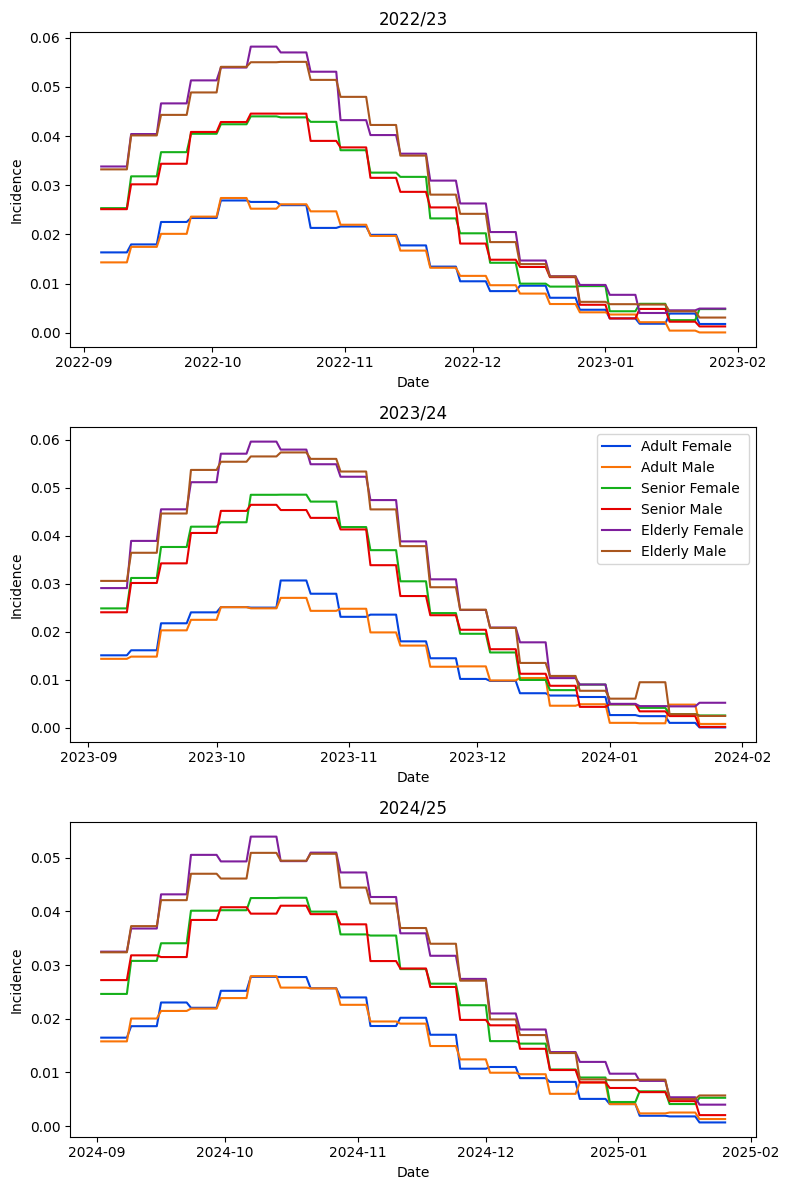

In [9]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=colors_map.get(hash((age_category, sex_category))),
            )
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [10]:
observations_prevalence = observations.copy()
observations_prevalence = observations_prevalence.sort_values(
    [
        "start_date",
        "end_date",
        "season",
        "season_start_date",
        "season_end_date",
        "sex",
        "age",
    ],
).reset_index(drop=True)
observations_prevalence["prevalence"] = (
    observations_prevalence.groupby(["season", "sex", "age"])["value"]
    .cumsum()
    .reset_index()["value"]
)
observations_prevalence

season season_start_date season_end_date start_date   end_date  \
0    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
1    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
2    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
3    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
4    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
..       ...               ...             ...        ...        ...   
373  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   
374  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   
375  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   
376  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   
377  2024/25        2024-09-02      2025-01-26 2025-01-20 2025-01-26   

    report_date     sex      age       type     value  prevalence  
0    2022-09-11  female    adult  incidence  0.016363    0.016363  
1    2022-09-11  female  elderly  incidence  0.033812    0.033812  
2    2022-09-11  female   senior  incidence  0.025353    0.025353  
3    2022-09-11    male    adult  incidence  0.014335    0.014335  
4    2022-09-11    male  elderly  incidence  0.033227    0.033227  
..          ...     ...      ...        ...       ...         ...  
373  2025-01-26  female  elderly  incidence  0.004000    0.643880  
374  2025-01-26  female   senior  incidence  0.005283    0.515504  
375  2025-01-26    male    adult  incidence  0.001323    0.315053  
376  2025-01-26    male  elderly  incidence  0.005713    0.626978  
377  2025-01-26    male   senior  incidence  0.002053    0.505175  

[378 rows x 11 columns]

In [11]:
prevalence_offsets = {}
for season_range in season_ranges:
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            season_params = params_grid[season_range.season]
            kwargs = {}
            for param in logistic_curve.parameters:
                kwargs[param] = (
                    season_params[param]
                    + season_params.get(sex_category, {}).get(param, 0)
                    + season_params.get(age_category, {}).get(param, 0)
                )
            prevalence_offsets[
                hash((season_range.season, age_category, sex_category))
            ] = logistic_curve.prevalence(0.0, **kwargs).eval()

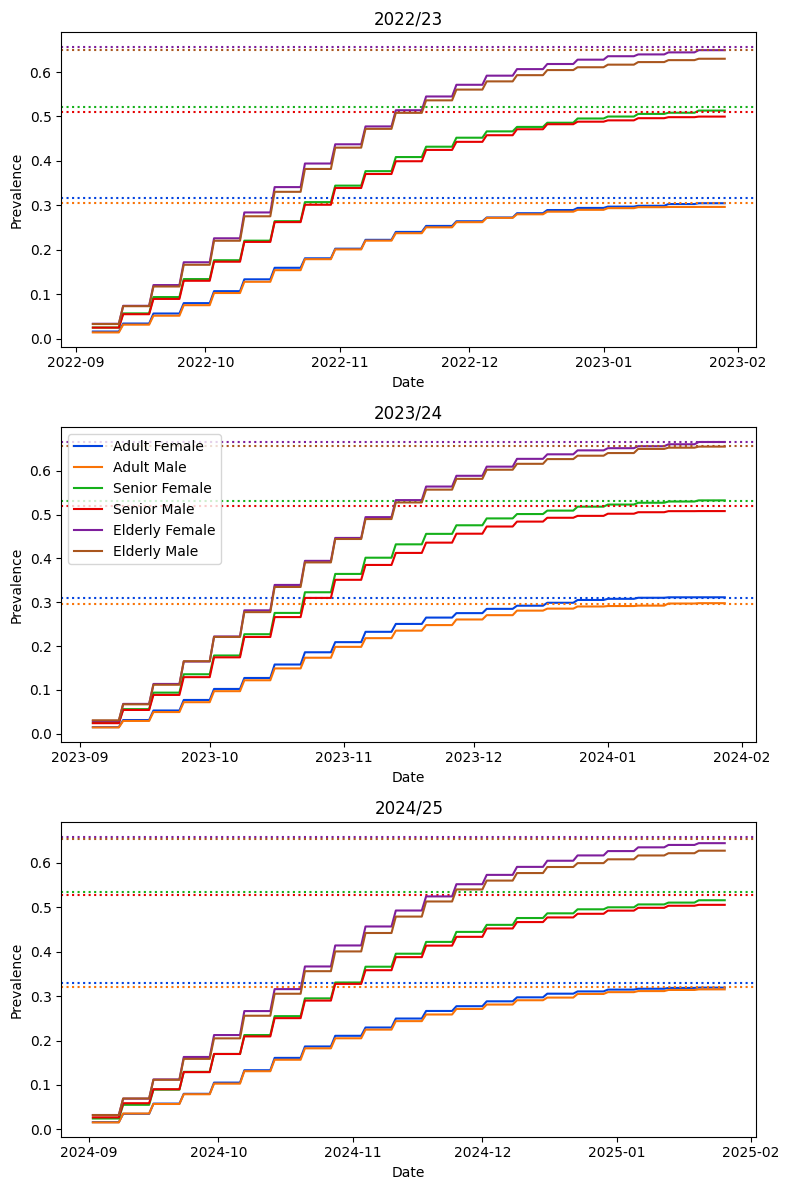

In [12]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=colors_map.get(hash((age_category, sex_category))),
            )
            ax.axhline(
                y=expit(
                    params_grid[season_range.season]["m"]
                    + params_grid[season_range.season]
                    .get(age_category, {})
                    .get("m", 0.0)
                    + params_grid[season_range.season]
                    .get(sex_category, {})
                    .get("m", 0.0),
                )
                - prevalence_offsets[
                    hash((season_range.season, age_category, sex_category))
                ],
                linestyle=":",
                color=colors_map.get(hash((age_category, sex_category))),
            )
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [13]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -0.5, "sigma": 0.05},
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.0, "sigma": 0.15},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 40.0, "sigma": 5.0},
        ),
        GaussianCovariate(
            parameter="m",
            covariate="age",
            mu=[1.0, 1.8],
            sigma=2 * [0.2],
            eta=2.0,
        ),
        GaussianCovariate(
            parameter="m",
            covariate="sex",
            mu=-0.05,
            sigma=0.01,
            eta=2.0,
        ),
    ],
    covariate_categories=[sex_cov, age_cov],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.001,
    # Custom keyword arguments
    constrain_prevalence=False,
    observation_sigma=5e-6,
    pooled_epsilon=True,
)
model

---

In [14]:
model_full_observations = model.add_observations(observations)

In [15]:
model_full_observations.build(debug=False)

In [16]:
model_full_observations.sample(
    tune=tune,
    draws=draws,
    chains=chains,
    random_seed=seed,
)

Running window adaptation


There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


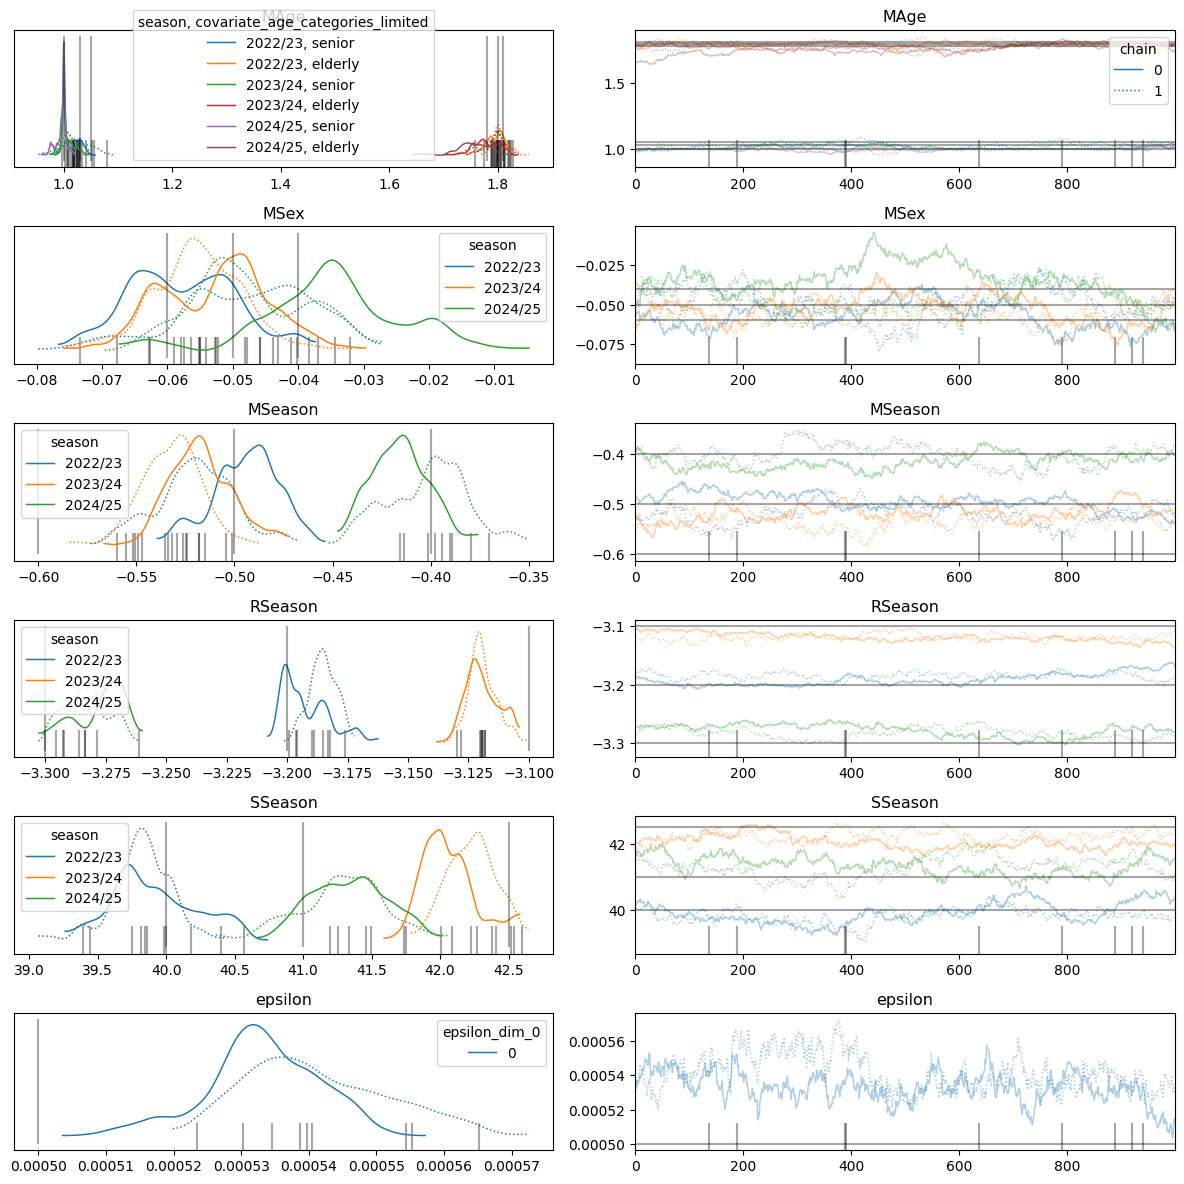

In [17]:
az.plot_trace(
    model_full_observations._trace,  # noqa: SLF001
    var_names=["MAge", "MSex", "MSeason", "RSeason", "SSeason", "epsilon"],
    lines=[
        (
            "MAge",
            {},
            [
                params_grid[season.season][age]["m"]
                for season in season_ranges
                for age in age_cov.categories[1:]
            ],
        ),
        (
            "MSex",
            {},
            [params_grid[season.season]["male"]["m"] for season in season_ranges],
        ),
        ("MSeason", {}, [params_grid[season.season]["m"] for season in season_ranges]),
        ("RSeason", {}, [params_grid[season.season]["r"] for season in season_ranges]),
        ("SSeason", {}, [params_grid[season.season]["s"] for season in season_ranges]),
        ("epsilon", {}, [true_epsilon]),
    ],
    legend=True,
    compact=True,
)
plt.tight_layout()

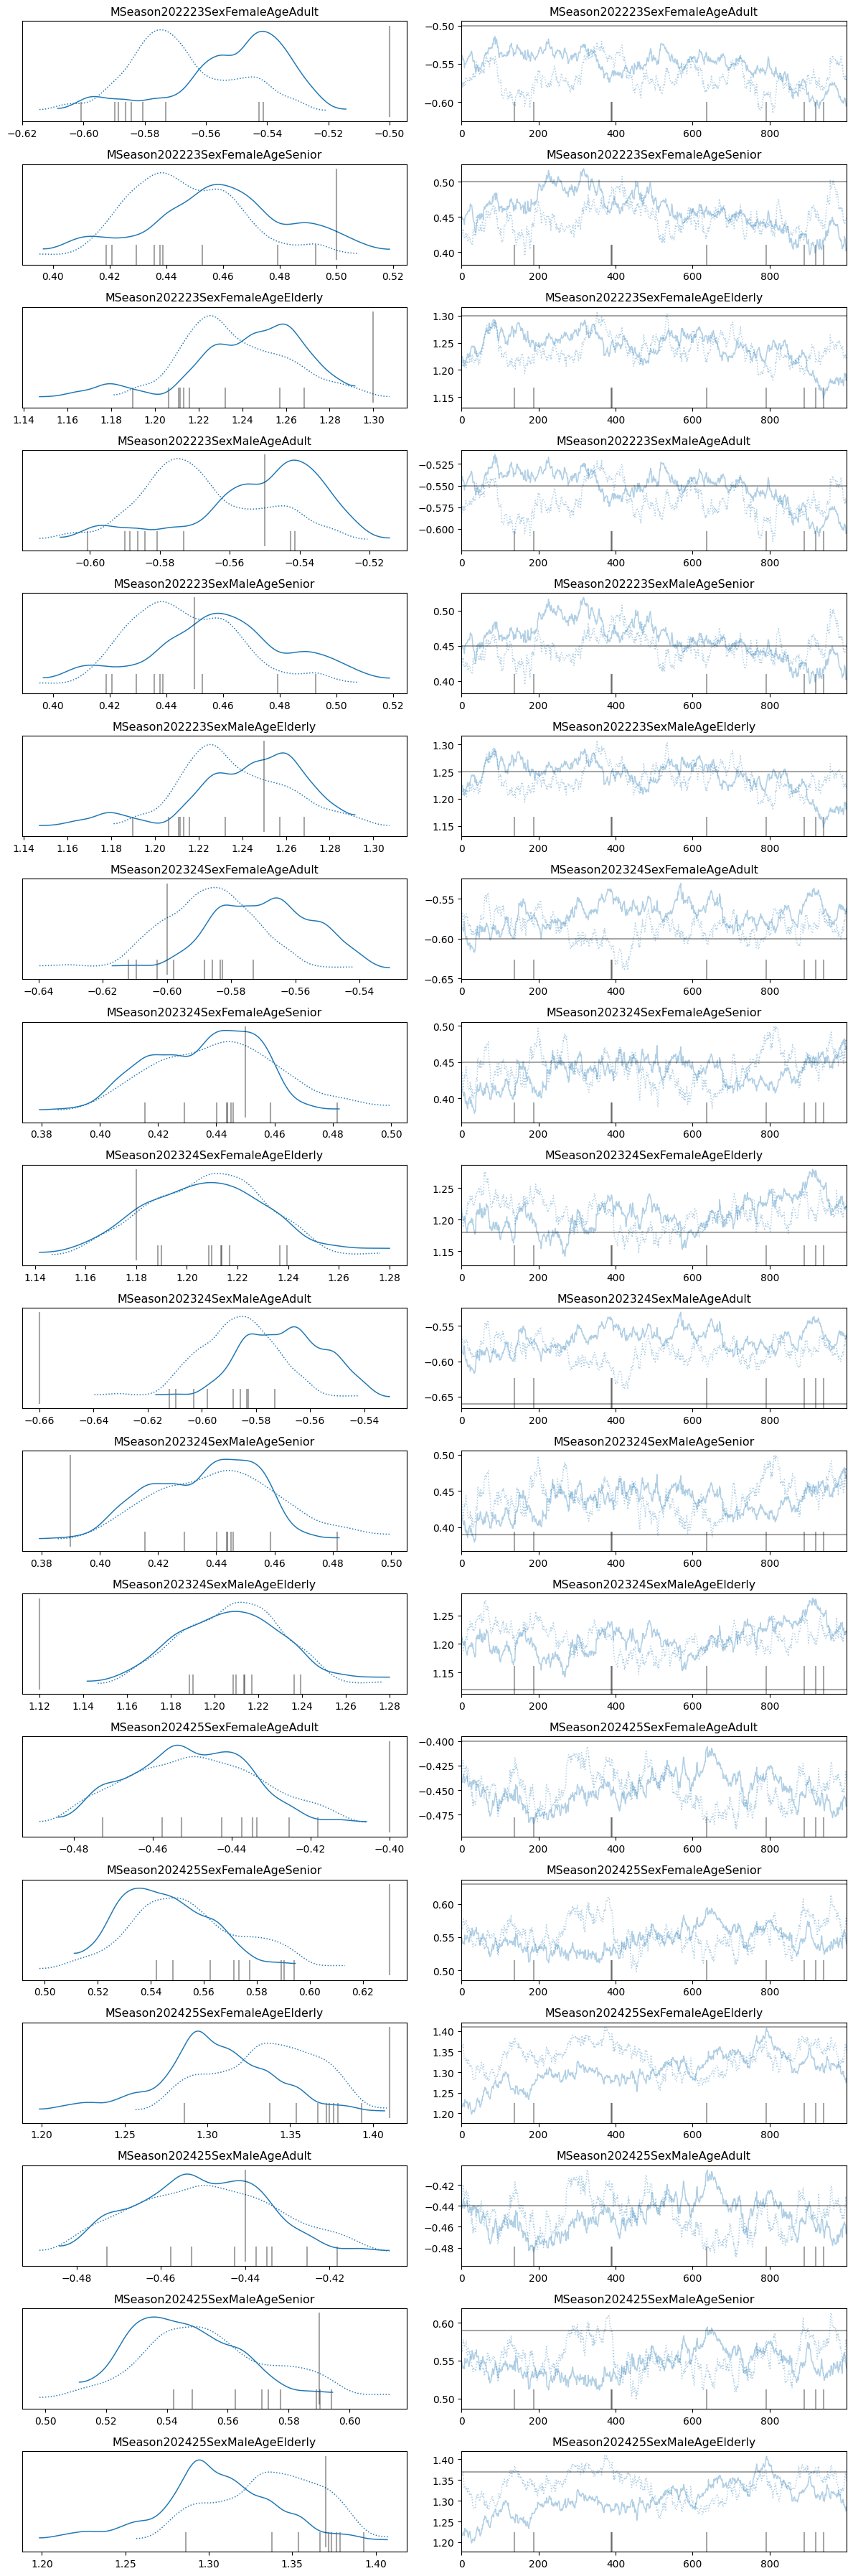

In [18]:
var_names_and_lines = {
    (
        f"{p[0].title()}Season{p[1].replace('/', '').title()}"
        f"Sex{p[2].title()}Age{p[3].title()}"
    ): p[4]
    for p in params
    if p[0] == "m"
}

az.plot_trace(
    model_full_observations._trace,  # noqa: SLF001
    var_names=list(var_names_and_lines.keys()),
    lines=[(k, {}, v) for k, v in var_names_and_lines.items()],
)
plt.tight_layout()

In [19]:
posterior_df = model_full_observations.dataframe()
posterior_df.head(10)

draw  chain   season       date     sex    age       type     value
0     0      0  2022/23 2022-09-05  female  adult  incidence  0.002117
1     0      0  2022/23 2022-09-06  female  adult  incidence  0.002546
2     0      0  2022/23 2022-09-07  female  adult  incidence  0.002691
3     0      0  2022/23 2022-09-08  female  adult  incidence  0.002292
4     0      0  2022/23 2022-09-09  female  adult  incidence  0.001759
5     0      0  2022/23 2022-09-10  female  adult  incidence  0.002283
6     0      0  2022/23 2022-09-11  female  adult  incidence  0.002671
7     0      0  2022/23 2022-09-12  female  adult  incidence  0.002086
8     0      0  2022/23 2022-09-13  female  adult  incidence  0.003093
9     0      0  2022/23 2022-09-14  female  adult  incidence  0.002957

In [20]:
posterior_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5292000 entries, 0 to 293999
Data columns (total 8 columns):
 #   Column  Dtype         
---  ------  -----         
 0   draw    int64         
 1   chain   int64         
 2   season  string        
 3   date    datetime64[ns]
 4   sex     string        
 5   age     string        
 6   type    string        
 7   value   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(4)
memory usage: 363.4 MB


In [21]:
posterior_df = (
    posterior_df.drop(columns=["type"])
    .rename(columns={"value": "incidence"})
    .sort_values(["draw", "chain", "season", "sex", "age", "date"])
    .reset_index(drop=True)
)
posterior_df["prevalence"] = (
    posterior_df.groupby(["draw", "chain", "season", "sex", "age"])["incidence"]
    .cumsum()
    .reset_index()["incidence"]
)
posterior_df

draw  chain   season       date     sex     age  incidence  \
0           0      0  2022/23 2022-09-05  female   adult   0.002117   
1           0      0  2022/23 2022-09-06  female   adult   0.002546   
2           0      0  2022/23 2022-09-07  female   adult   0.002691   
3           0      0  2022/23 2022-09-08  female   adult   0.002292   
4           0      0  2022/23 2022-09-09  female   adult   0.001759   
...       ...    ...      ...        ...     ...     ...        ...   
5291995   999      1  2024/25 2025-01-22    male  senior   0.000871   
5291996   999      1  2024/25 2025-01-23    male  senior   0.000213   
5291997   999      1  2024/25 2025-01-24    male  senior   0.000246   
5291998   999      1  2024/25 2025-01-25    male  senior   0.000609   
5291999   999      1  2024/25 2025-01-26    male  senior   0.000070   

         prevalence  
0          0.002117  
1          0.004663  
2          0.007354  
3          0.009647  
4          0.011405  
...             ...  
5291995    0.504027  
5291996    0.504240  
5291997    0.504486  
5291998    0.505095  
5291999    0.505165  

[5292000 rows x 8 columns]

In [22]:
draws_max = 100
chains_and_draws = (
    posterior_df[["chain", "draw"]].drop_duplicates().reset_index(drop=True)
)
chains_and_draws = chains_and_draws[chains_and_draws["draw"] <= draws_max]
chains_and_draws

chain  draw
0        0     0
1        1     0
2        0     1
3        1     1
4        0     2
..     ...   ...
197      1    98
198      0    99
199      1    99
200      0   100
201      1   100

[202 rows x 2 columns]

In [23]:
posterior_df_with_index = posterior_df.set_index(
    keys=["chain", "draw", "season", "sex", "age"],
)
posterior_df_with_index = posterior_df_with_index.query("draw <= @draws_max")
posterior_df_with_index

date  incidence  prevalence
chain draw season  sex    age                                     
0     0    2022/23 female adult  2022-09-05   0.002117    0.002117
                          adult  2022-09-06   0.002546    0.004663
                          adult  2022-09-07   0.002691    0.007354
                          adult  2022-09-08   0.002292    0.009647
                          adult  2022-09-09   0.001759    0.011405
...                                     ...        ...         ...
1     100  2024/25 male   senior 2025-01-22   0.000025    0.504213
                          senior 2025-01-23   0.000527    0.504741
                          senior 2025-01-24   0.000235    0.504976
                          senior 2025-01-25   0.000063    0.505039
                          senior 2025-01-26   0.000179    0.505218

[534492 rows x 3 columns]

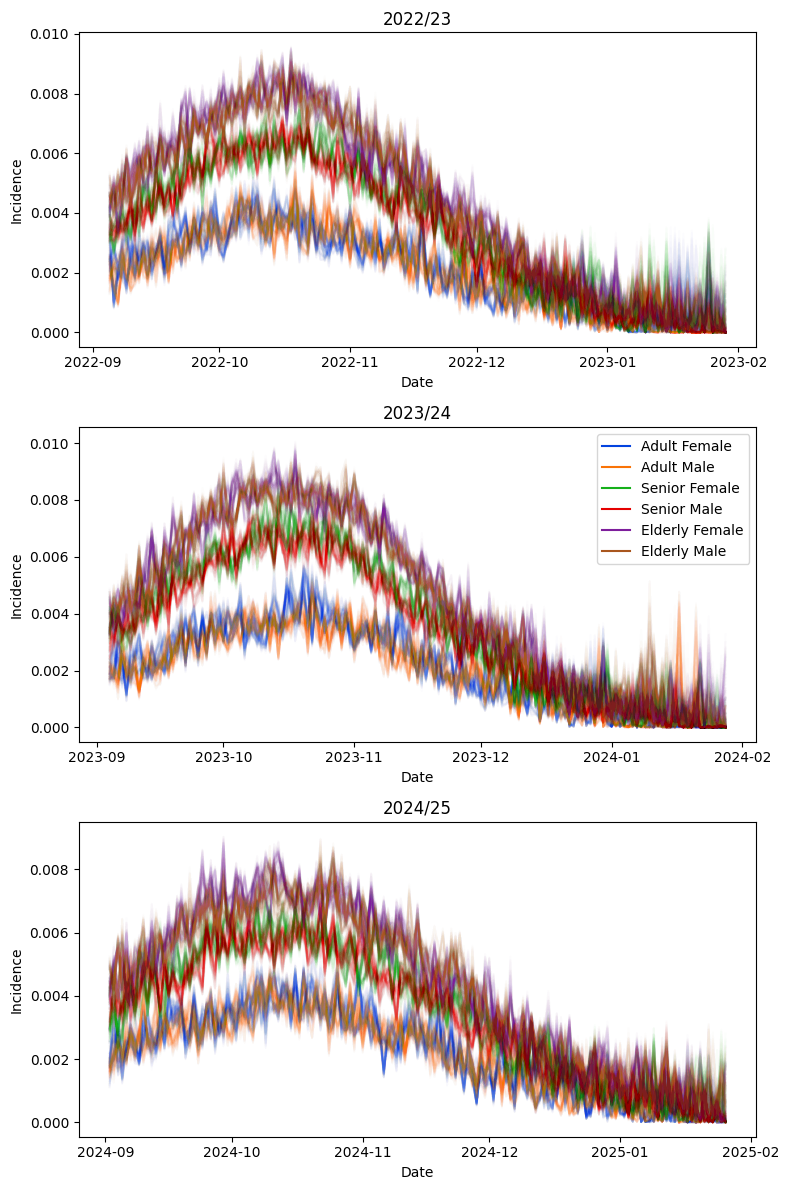

In [24]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")

    custom_legend_elements = []
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            for row in chains_and_draws.itertuples():
                posterior_subset = posterior_df_with_index.query(
                    f"chain == {row.chain} and draw == {row.draw} "
                    f"and season == '{season_range.season}' "
                    f"and sex == '{sex_category}' and age == '{age_category}'",
                ).copy()
                if row.chain == 0 and row.draw == 0:
                    custom_legend_elements.append(
                        (
                            Line2D([0], [0], color=color),
                            f"{age_category.title()} {sex_category.title()}",
                        ),
                    )
                ax.plot(
                    posterior_subset["date"].tolist(),
                    posterior_subset["incidence"].tolist(),
                    color=color,
                    linestyle="-",
                    alpha=0.01,
                )
    if i == (len(season_ranges) // 2):
        custom_lines = [line[0] for line in custom_legend_elements]
        labels = [line[1] for line in custom_legend_elements]
        ax.legend(custom_lines, labels)

fig.tight_layout()
plt.show()

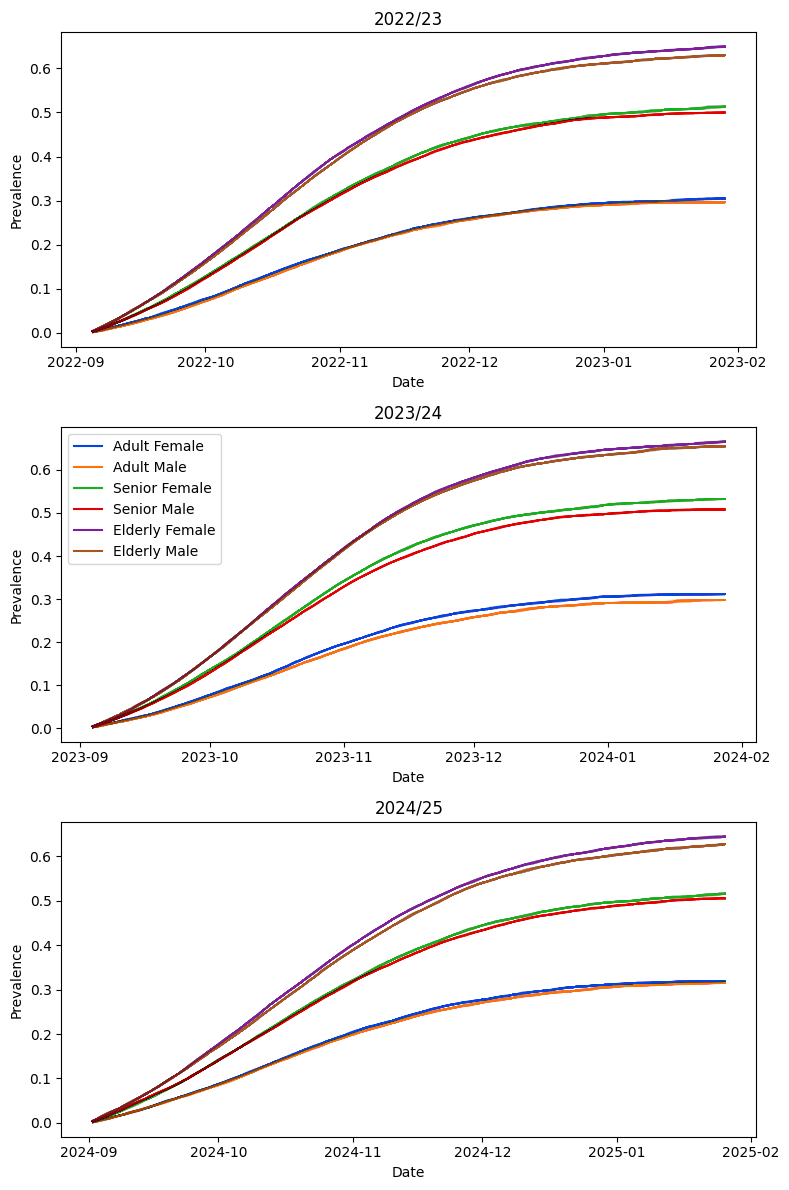

In [25]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")

    custom_legend_elements = []
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            for row in chains_and_draws.itertuples():
                posterior_subset = posterior_df_with_index.query(
                    f"chain == {row.chain} and draw == {row.draw} "
                    f"and season == '{season_range.season}' "
                    f"and sex == '{sex_category}' and age == '{age_category}'",
                ).copy()
                if row.chain == 0 and row.draw == 0:
                    custom_legend_elements.append(
                        (
                            Line2D([0], [0], color=color),
                            f"{age_category.title()} {sex_category.title()}",
                        ),
                    )
                ax.plot(
                    posterior_subset["date"].tolist(),
                    posterior_subset["prevalence"].tolist(),
                    color=color,
                    linestyle="-",
                    alpha=0.01,
                )
    if i == (len(season_ranges) // 2):
        custom_lines = [line[0] for line in custom_legend_elements]
        custom_labels = [line[1] for line in custom_legend_elements]
        ax.legend(custom_lines, custom_labels)

fig.tight_layout()
plt.show()

In [26]:
range_days_to_freq = {
    6: "W",
}
if range_days > 0:
    if (freq := range_days_to_freq.get(range_days)) is None:
        msg = (
            f"Range days {range_days} not supported, "
            f"please add to `range_days_to_freq` dictionary."
        )
        raise RuntimeError(msg)
    incidence_posterior_df = (
        posterior_df.groupby(
            [
                "chain",
                "draw",
                "season",
                pd.Grouper(key="date", freq=freq),
                "sex",
                "age",
            ],
        )["incidence"]
        .sum()
        .reset_index()
    )
incidence_posterior_df = (
    incidence_posterior_df if range_days > 0 else posterior_df
).rename(columns={"date": "end_date"})
incidence_posterior_df["start_date"] = incidence_posterior_df[
    "end_date"
] - pd.Timedelta(days=range_days)
incidence_posterior_df = (
    incidence_posterior_df.groupby(["season", "start_date", "end_date", "sex", "age"])[
        "incidence"
    ]
    .agg(
        [
            lambda x: np.quantile(x, conf_lower),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, conf_higher),
        ],
    )
    .reset_index()
)
incidence_posterior_df = incidence_posterior_df.rename(
    columns={
        incidence_posterior_df.columns[-3]: "lower",
        incidence_posterior_df.columns[-2]: "median",
        incidence_posterior_df.columns[-1]: "upper",
    },
)
incidence_posterior_df

season start_date   end_date     sex      age     lower    median  \
0    2022/23 2022-09-05 2022-09-11  female    adult  0.016354  0.016363   
1    2022/23 2022-09-05 2022-09-11  female  elderly  0.033803  0.033812   
2    2022/23 2022-09-05 2022-09-11  female   senior  0.025343  0.025353   
3    2022/23 2022-09-05 2022-09-11    male    adult  0.014326  0.014335   
4    2022/23 2022-09-05 2022-09-11    male  elderly  0.033217  0.033227   
..       ...        ...        ...     ...      ...       ...       ...   
373  2024/25 2025-01-20 2025-01-26  female  elderly  0.003990  0.004000   
374  2024/25 2025-01-20 2025-01-26  female   senior  0.005274  0.005283   
375  2024/25 2025-01-20 2025-01-26    male    adult  0.001313  0.001323   
376  2024/25 2025-01-20 2025-01-26    male  elderly  0.005703  0.005713   
377  2024/25 2025-01-20 2025-01-26    male   senior  0.002043  0.002053   

        upper  
0    0.016373  
1    0.033822  
2    0.025363  
3    0.014345  
4    0.033237  
..        ...  
373  0.004010  
374  0.005293  
375  0.001333  
376  0.005723  
377  0.002063  

[378 rows x 8 columns]

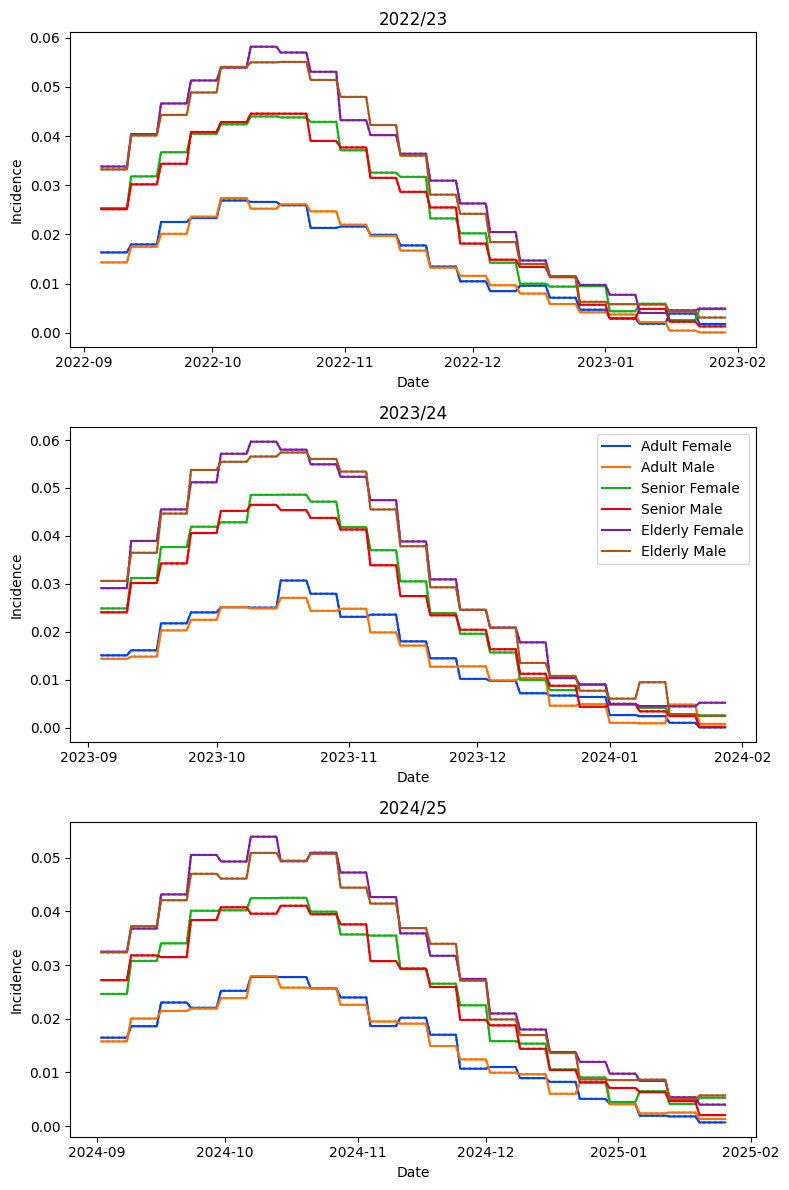

In [27]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = incidence_posterior_df[
                (incidence_posterior_df["season"] == season_range.season)
                & (incidence_posterior_df["age"] == age_category)
                & (incidence_posterior_df["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    summary_posterior_subset["start_date"].tolist(),
                    summary_posterior_subset["end_date"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    summary_posterior_subset["median"].tolist(),
                    summary_posterior_subset["median"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.plot(x, y, color=color, linestyle=":")

            y1 = [
                el
                for pair in zip(
                    summary_posterior_subset["lower"].tolist(),
                    summary_posterior_subset["lower"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y2 = [
                el
                for pair in zip(
                    summary_posterior_subset["upper"].tolist(),
                    summary_posterior_subset["upper"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [28]:
prevalence_posterior_df = (
    posterior_df.groupby(["season", "date", "sex", "age"])["prevalence"]
    .agg(
        [
            lambda x: np.quantile(x, conf_lower),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, conf_higher),
        ],
    )
    .reset_index()
)
prevalence_posterior_df = prevalence_posterior_df.rename(
    columns={
        prevalence_posterior_df.columns[-3]: "lower",
        prevalence_posterior_df.columns[-2]: "median",
        prevalence_posterior_df.columns[-1]: "upper",
    },
)
prevalence_posterior_df

season       date     sex      age     lower    median     upper
0     2022/23 2022-09-05  female    adult  0.001089  0.002367  0.003486
1     2022/23 2022-09-05  female  elderly  0.003839  0.004403  0.005160
2     2022/23 2022-09-05  female   senior  0.002624  0.003489  0.004539
3     2022/23 2022-09-05    male    adult  0.001133  0.001858  0.002786
4     2022/23 2022-09-05    male  elderly  0.003713  0.004412  0.005333
...       ...        ...     ...      ...       ...       ...       ...
2641  2024/25 2025-01-26  female  elderly  0.643833  0.643879  0.643923
2642  2024/25 2025-01-26  female   senior  0.515461  0.515504  0.515549
2643  2024/25 2025-01-26    male    adult  0.315008  0.315054  0.315097
2644  2024/25 2025-01-26    male  elderly  0.626932  0.626978  0.627024
2645  2024/25 2025-01-26    male   senior  0.505126  0.505175  0.505221

[2646 rows x 7 columns]

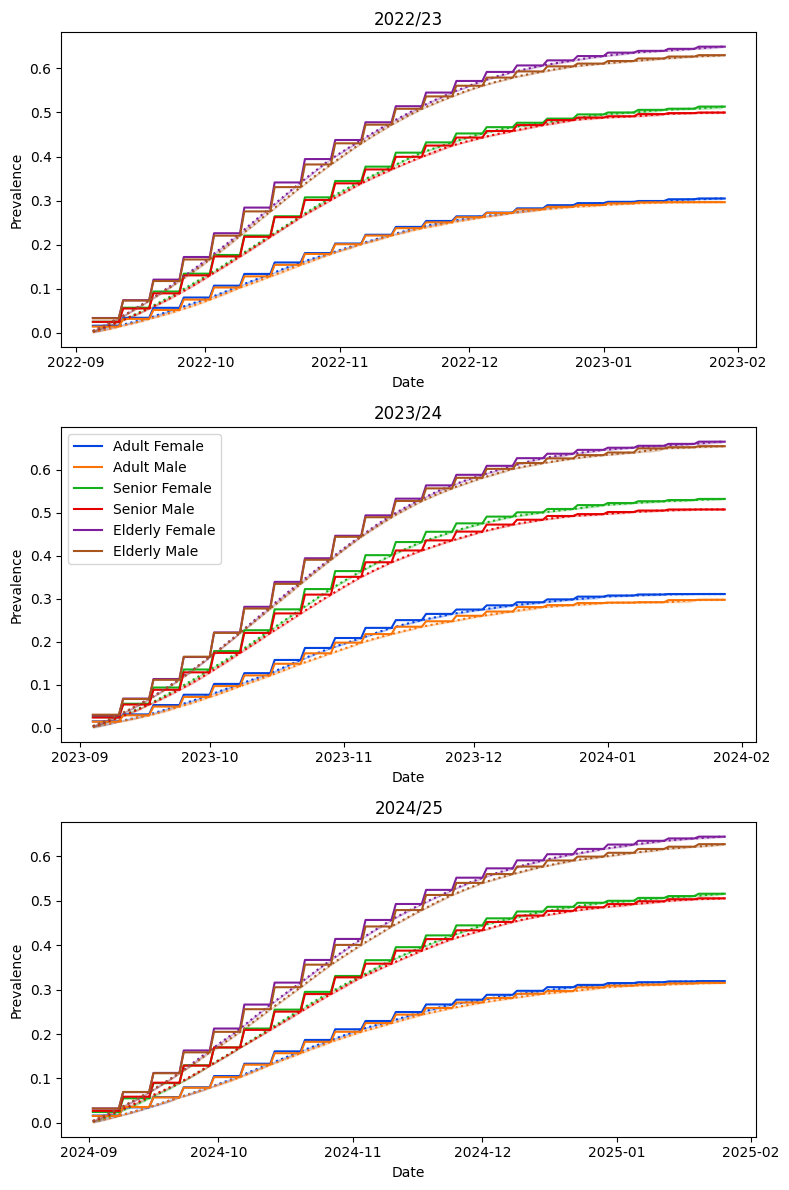

In [29]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = prevalence_posterior_df[
                (prevalence_posterior_df["season"] == season_range.season)
                & (prevalence_posterior_df["age"] == age_category)
                & (prevalence_posterior_df["sex"] == sex_category)
            ]

            x = summary_posterior_subset["date"].tolist()
            y = summary_posterior_subset["median"].tolist()
            ax.plot(x, y, color=color, linestyle=":")

            y1 = summary_posterior_subset["lower"].tolist()
            y2 = summary_posterior_subset["upper"].tolist()
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

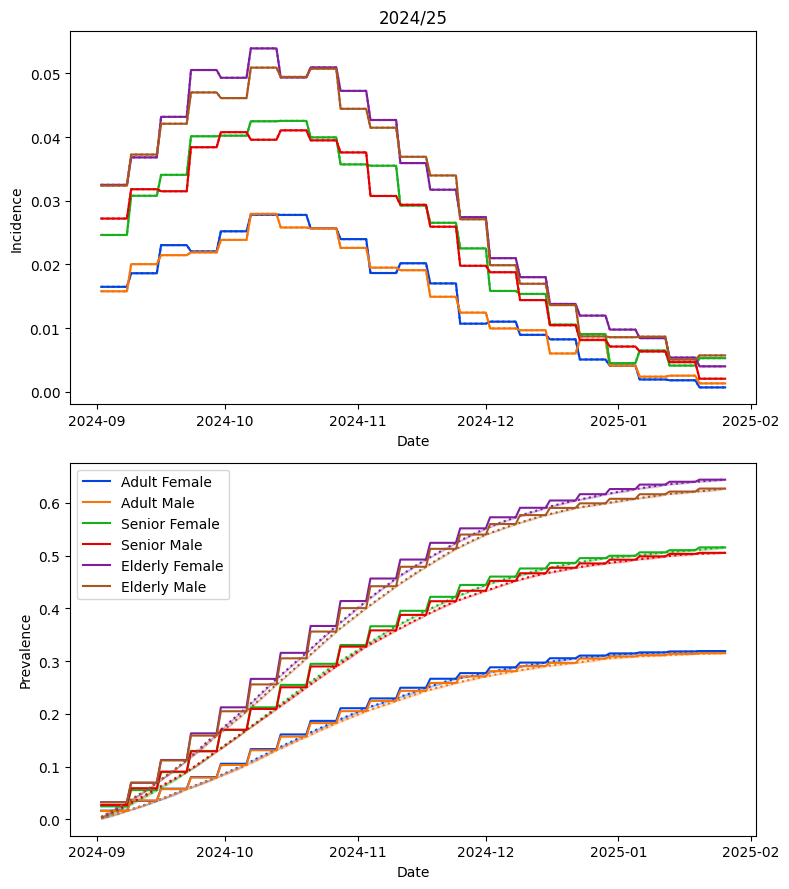

In [30]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 9),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

ax = axes[0]
ax.set_title("2024/25")
ax.set_xlabel("Date")
ax.set_ylabel("Incidence")
for age_category in age_cov.categories:
    for sex_category in sex_cov.categories:
        color = colors_map[hash((age_category, sex_category))]
        observations_subset = observations[
            (observations["season"] == "2024/25")
            & (observations["age"] == age_category)
            & (observations["sex"] == sex_category)
        ]
        x = [
            el
            for pair in zip(
                observations_subset["start_date"].tolist(),
                observations_subset["end_date"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        y = [
            el
            for pair in zip(
                observations_subset["value"].tolist(),
                observations_subset["value"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        ax.plot(
            x,
            y,
            label=f"{age_category.title()} {sex_category.title()}",
            color=color,
            linestyle="-",
        )

        summary_posterior_subset = incidence_posterior_df[
            (incidence_posterior_df["season"] == season_range.season)
            & (incidence_posterior_df["age"] == age_category)
            & (incidence_posterior_df["sex"] == sex_category)
        ]
        x = [
            el
            for pair in zip(
                summary_posterior_subset["start_date"].tolist(),
                summary_posterior_subset["end_date"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        y = [
            el
            for pair in zip(
                summary_posterior_subset["median"].tolist(),
                summary_posterior_subset["median"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        ax.plot(x, y, color=color, linestyle=":")

        y1 = [
            el
            for pair in zip(
                summary_posterior_subset["lower"].tolist(),
                summary_posterior_subset["lower"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        y2 = [
            el
            for pair in zip(
                summary_posterior_subset["upper"].tolist(),
                summary_posterior_subset["upper"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        ax.fill_between(x, y1, y2, color=color, alpha=0.2)


ax = axes[1]
ax.set_xlabel("Date")
ax.set_ylabel("Prevalence")
for age_category in age_cov.categories:
    for sex_category in sex_cov.categories:
        color = colors_map[hash((age_category, sex_category))]
        observations_subset = observations_prevalence[
            (observations_prevalence["season"] == season_range.season)
            & (observations_prevalence["age"] == age_category)
            & (observations_prevalence["sex"] == sex_category)
        ]
        x = [
            el
            for pair in zip(
                observations_subset["start_date"].tolist(),
                observations_subset["end_date"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        y = [
            el
            for pair in zip(
                observations_subset["prevalence"].tolist(),
                observations_subset["prevalence"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        ax.plot(
            x,
            y,
            label=f"{age_category.title()} {sex_category.title()}",
            color=color,
            linestyle="-",
        )

        summary_posterior_subset = prevalence_posterior_df[
            (prevalence_posterior_df["season"] == season_range.season)
            & (prevalence_posterior_df["age"] == age_category)
            & (prevalence_posterior_df["sex"] == sex_category)
        ]

        x = summary_posterior_subset["date"].tolist()
        y = summary_posterior_subset["median"].tolist()
        ax.plot(x, y, color=color, linestyle=":")

        y1 = summary_posterior_subset["lower"].tolist()
        y2 = summary_posterior_subset["upper"].tolist()
        ax.fill_between(x, y1, y2, color=color, alpha=0.2)
ax.legend()


fig.tight_layout()
plt.show()

---

In [31]:
partial_observations = observations.copy()
partial_observations = partial_observations[
    (partial_observations["season"] == "2022/23")
    | (partial_observations["season"] == "2023/24")
    | (
        (partial_observations["season"] == "2024/25")
        & (partial_observations["end_date"].dt.date < date(2024, 10, 1))
    )
]
partial_observations

season season_start_date season_end_date start_date   end_date  \
0    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
1    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
2    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
3    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
4    2022/23        2022-09-05      2023-01-29 2022-09-05 2022-09-11   
..       ...               ...             ...        ...        ...   
271  2024/25        2024-09-02      2025-01-26 2024-09-23 2024-09-29   
272  2024/25        2024-09-02      2025-01-26 2024-09-23 2024-09-29   
273  2024/25        2024-09-02      2025-01-26 2024-09-23 2024-09-29   
274  2024/25        2024-09-02      2025-01-26 2024-09-23 2024-09-29   
275  2024/25        2024-09-02      2025-01-26 2024-09-23 2024-09-29   

    report_date     sex      age       type     value  
0    2022-09-11  female    adult  incidence  0.016363  
1    2022-09-11  female   senior  incidence  0.025353  
2    2022-09-11  female  elderly  incidence  0.033812  
3    2022-09-11    male    adult  incidence  0.014335  
4    2022-09-11    male   senior  incidence  0.025144  
..          ...     ...      ...        ...       ...  
271  2024-09-29  female   senior  incidence  0.040127  
272  2024-09-29  female  elderly  incidence  0.050529  
273  2024-09-29    male    adult  incidence  0.021889  
274  2024-09-29    male   senior  incidence  0.038406  
275  2024-09-29    male  elderly  incidence  0.047011  

[276 rows x 10 columns]

In [33]:
model_partial_observations = model.add_observations(partial_observations)

In [34]:
model_partial_observations.build(debug=False)

In [35]:
model_partial_observations.sample(
    tune=tune,
    draws=draws,
    chains=chains,
    random_seed=seed,
)

Running window adaptation


We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


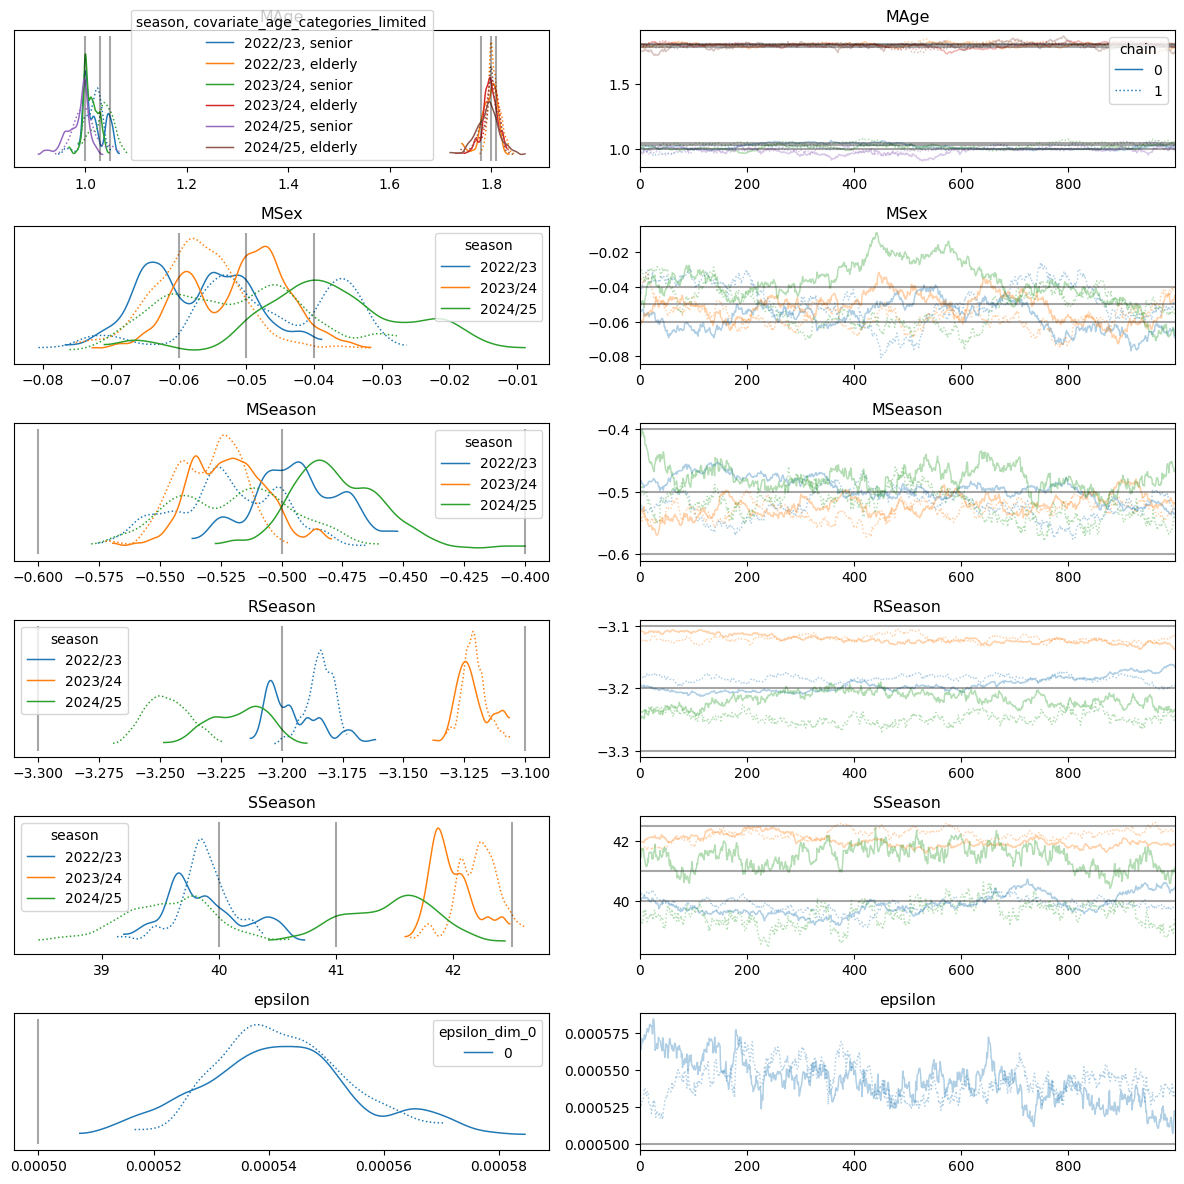

In [36]:
az.plot_trace(
    model_partial_observations._trace,  # noqa: SLF001
    var_names=["MAge", "MSex", "MSeason", "RSeason", "SSeason", "epsilon"],
    lines=[
        (
            "MAge",
            {},
            [
                params_grid[season.season][age]["m"]
                for season in season_ranges
                for age in age_cov.categories[1:]
            ],
        ),
        (
            "MSex",
            {},
            [params_grid[season.season]["male"]["m"] for season in season_ranges],
        ),
        ("MSeason", {}, [params_grid[season.season]["m"] for season in season_ranges]),
        ("RSeason", {}, [params_grid[season.season]["r"] for season in season_ranges]),
        ("SSeason", {}, [params_grid[season.season]["s"] for season in season_ranges]),
        ("epsilon", {}, [true_epsilon]),
    ],
    legend=True,
    compact=True,
)
plt.tight_layout()

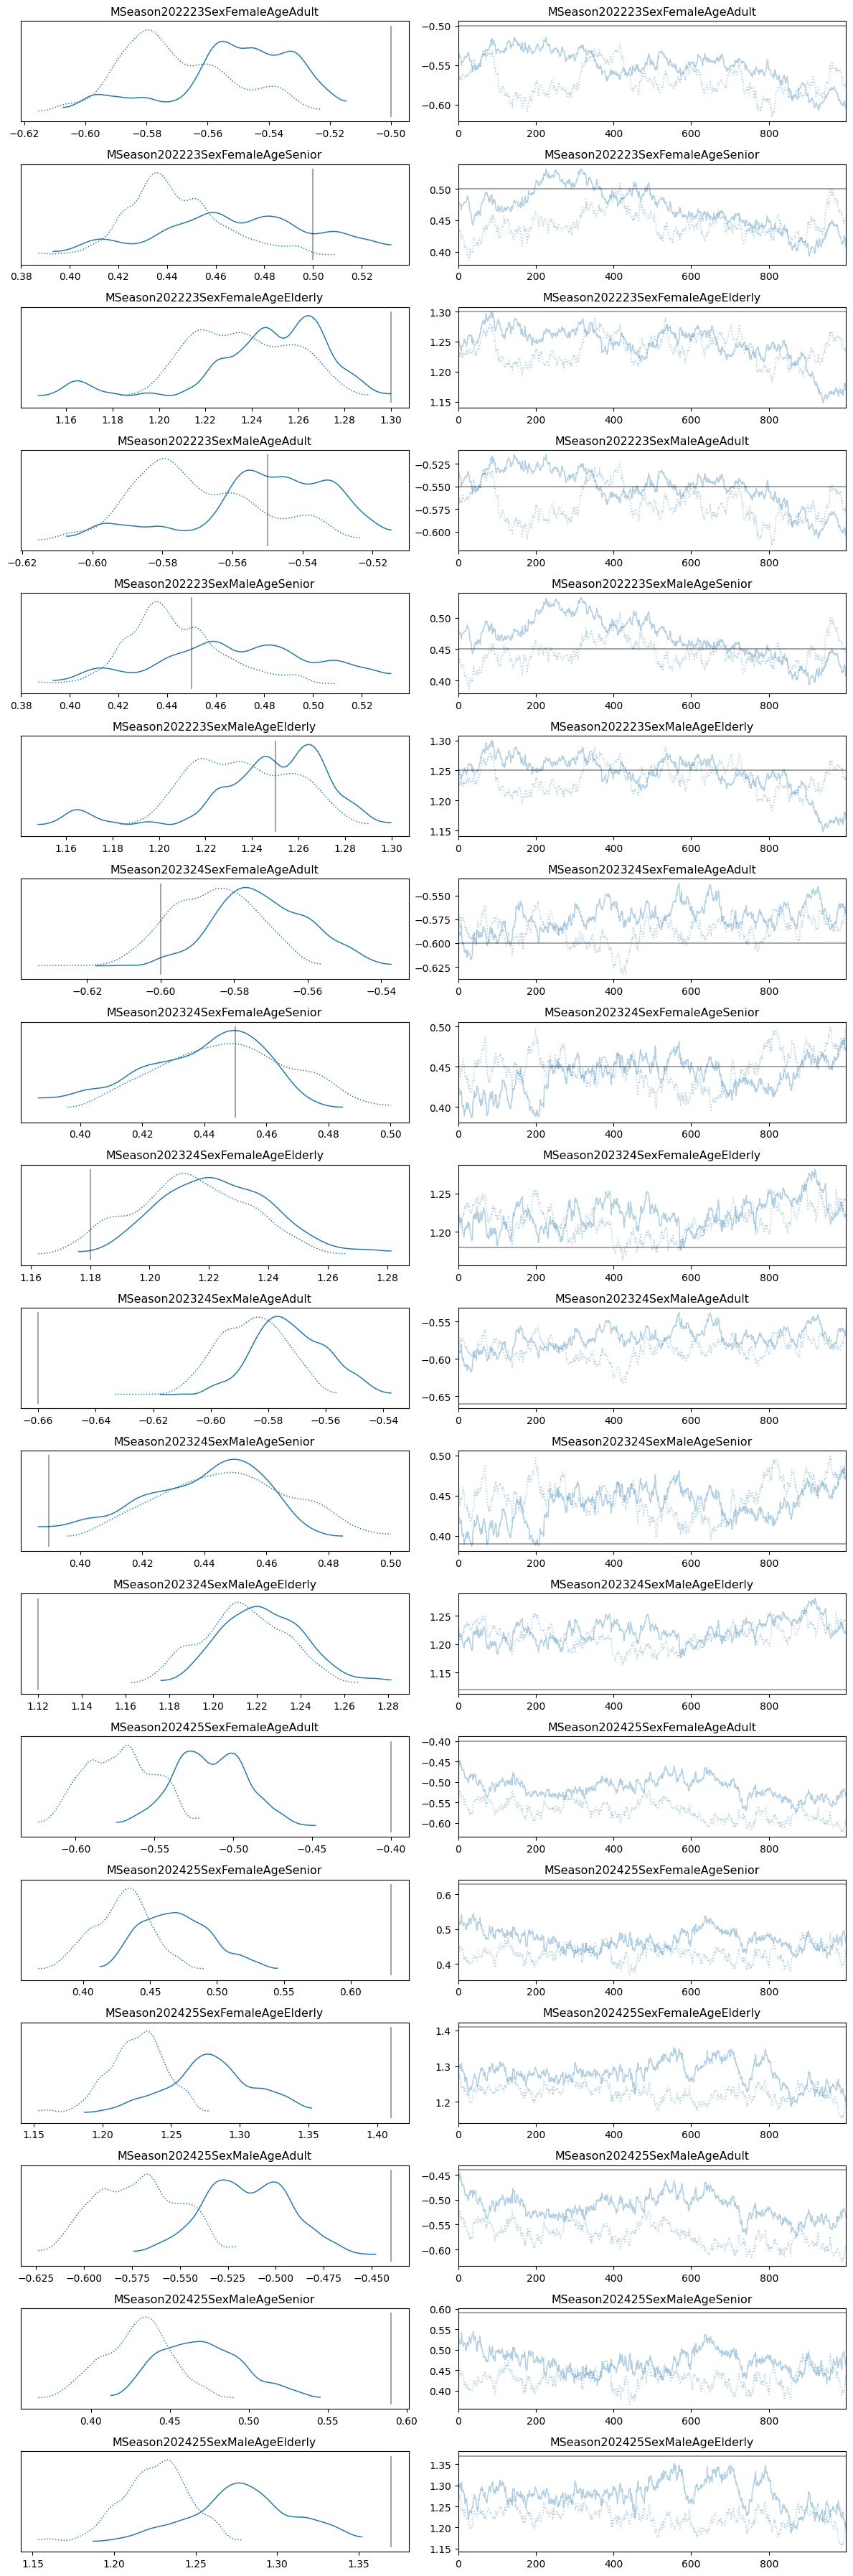

In [37]:
var_names_and_lines = {
    (
        f"{p[0].title()}Season{p[1].replace('/', '').title()}"
        f"Sex{p[2].title()}Age{p[3].title()}"
    ): p[4]
    for p in params
    if p[0] == "m"
}

az.plot_trace(
    model_partial_observations._trace,  # noqa: SLF001
    var_names=list(var_names_and_lines.keys()),
    lines=[(k, {}, v) for k, v in var_names_and_lines.items()],
)
plt.tight_layout()

In [38]:
partial_posterior_df = model_partial_observations.dataframe()
partial_posterior_df.head(10)

draw  chain   season       date     sex    age       type     value
0     0      0  2022/23 2022-09-05  female  adult  incidence  0.002017
1     0      0  2022/23 2022-09-06  female  adult  incidence  0.002187
2     0      0  2022/23 2022-09-07  female  adult  incidence  0.002063
3     0      0  2022/23 2022-09-08  female  adult  incidence  0.002700
4     0      0  2022/23 2022-09-09  female  adult  incidence  0.002177
5     0      0  2022/23 2022-09-10  female  adult  incidence  0.002657
6     0      0  2022/23 2022-09-11  female  adult  incidence  0.002565
7     0      0  2022/23 2022-09-12  female  adult  incidence  0.002043
8     0      0  2022/23 2022-09-13  female  adult  incidence  0.004088
9     0      0  2022/23 2022-09-14  female  adult  incidence  0.002566

In [39]:
partial_posterior_df = (
    partial_posterior_df.drop(columns=["type"])
    .rename(columns={"value": "incidence"})
    .sort_values(["draw", "chain", "season", "sex", "age", "date"])
    .reset_index(drop=True)
)
partial_posterior_df["prevalence"] = (
    partial_posterior_df.groupby(["draw", "chain", "season", "sex", "age"])["incidence"]
    .cumsum()
    .reset_index()["incidence"]
)
partial_posterior_df

draw  chain   season       date     sex     age  incidence  \
0           0      0  2022/23 2022-09-05  female   adult   0.002017   
1           0      0  2022/23 2022-09-06  female   adult   0.002187   
2           0      0  2022/23 2022-09-07  female   adult   0.002063   
3           0      0  2022/23 2022-09-08  female   adult   0.002700   
4           0      0  2022/23 2022-09-09  female   adult   0.002177   
...       ...    ...      ...        ...     ...     ...        ...   
5291995   999      1  2024/25 2025-01-22    male  senior   0.001682   
5291996   999      1  2024/25 2025-01-23    male  senior   0.000267   
5291997   999      1  2024/25 2025-01-24    male  senior   0.000544   
5291998   999      1  2024/25 2025-01-25    male  senior   0.001517   
5291999   999      1  2024/25 2025-01-26    male  senior   0.000039   

         prevalence  
0          0.002017  
1          0.004204  
2          0.006267  
3          0.008966  
4          0.011143  
...             ...  
5291995    0.484880  
5291996    0.485147  
5291997    0.485691  
5291998    0.487208  
5291999    0.487247  

[5292000 rows x 8 columns]

In [40]:
draws_max = 100
chains_and_draws = (
    partial_posterior_df[["chain", "draw"]].drop_duplicates().reset_index(drop=True)
)
chains_and_draws = chains_and_draws[chains_and_draws["draw"] <= draws_max]
chains_and_draws

chain  draw
0        0     0
1        1     0
2        0     1
3        1     1
4        0     2
..     ...   ...
197      1    98
198      0    99
199      1    99
200      0   100
201      1   100

[202 rows x 2 columns]

In [41]:
partial_posterior_df_with_index = partial_posterior_df.set_index(
    keys=["chain", "draw", "season", "sex", "age"],
)
partial_posterior_df_with_index = partial_posterior_df_with_index.query(
    "draw <= @draws_max",
)
partial_posterior_df_with_index

date     incidence  prevalence
chain draw season  sex    age                                        
0     0    2022/23 female adult  2022-09-05  2.017145e-03    0.002017
                          adult  2022-09-06  2.186534e-03    0.004204
                          adult  2022-09-07  2.062977e-03    0.006267
                          adult  2022-09-08  2.699657e-03    0.008966
                          adult  2022-09-09  2.176593e-03    0.011143
...                                     ...           ...         ...
1     100  2024/25 male   senior 2025-01-22  6.836833e-07    0.478174
                          senior 2025-01-23  2.424059e-04    0.478416
                          senior 2025-01-24  2.113504e-04    0.478628
                          senior 2025-01-25  8.339628e-05    0.478711
                          senior 2025-01-26  1.000949e-04    0.478811

[534492 rows x 3 columns]

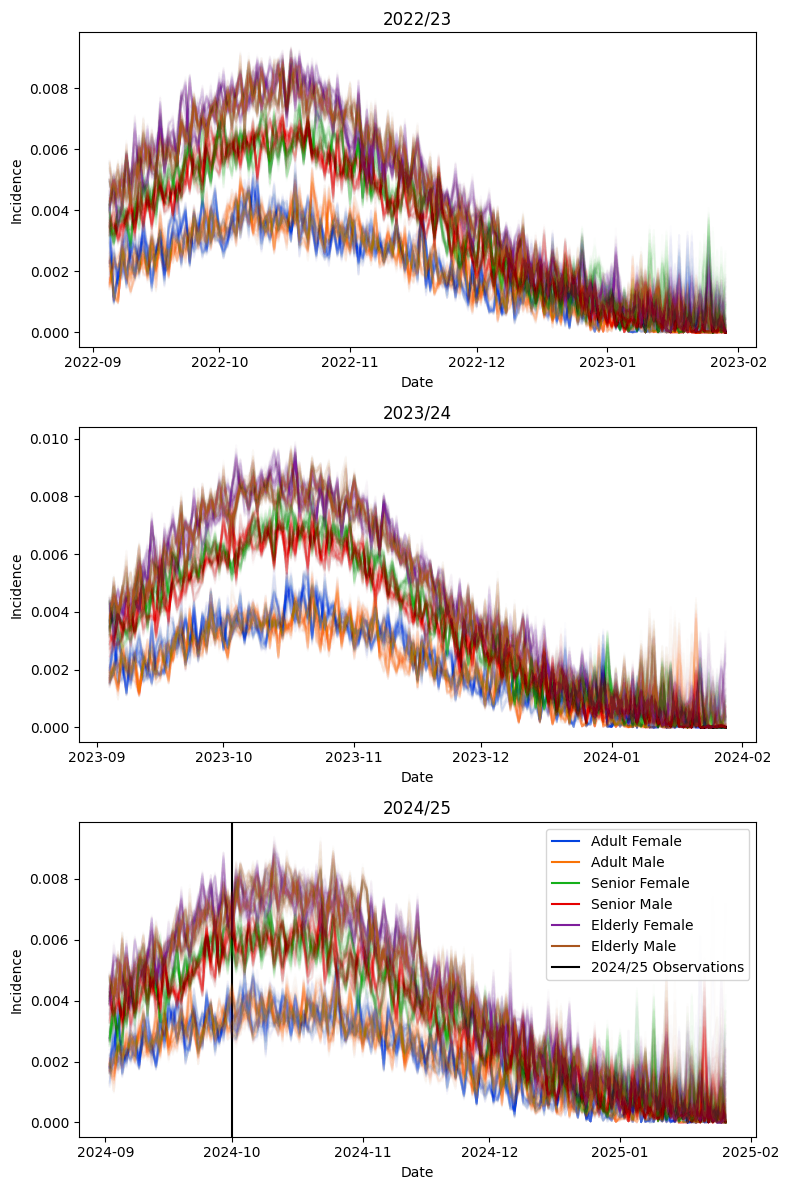

In [42]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")

    if season_range.season == "2024/25":
        ax.axvline(
            x=date(2024, 10, 1),
            color="black",
            linestyle="-",
            label="2024/25 Partial Observations",
        )

    custom_legend_elements = []
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            for row in chains_and_draws.itertuples():
                posterior_subset = partial_posterior_df_with_index.query(
                    f"chain == {row.chain} and draw == {row.draw} "
                    f"and season == '{season_range.season}' "
                    f"and sex == '{sex_category}' and age == '{age_category}'",
                ).copy()
                if row.chain == 0 and row.draw == 0:
                    custom_legend_elements.append(
                        (
                            Line2D([0], [0], color=color),
                            f"{age_category.title()} {sex_category.title()}",
                        ),
                    )
                ax.plot(
                    posterior_subset["date"].tolist(),
                    posterior_subset["incidence"].tolist(),
                    color=color,
                    linestyle="-",
                    alpha=0.01,
                )

    if season_range.season == "2024/25":
        custom_legend_elements.append(
            (
                Line2D([0], [0], color="black", linestyle="-"),
                "2024/25 Observations",
            ),
        )
        custom_lines = [line[0] for line in custom_legend_elements]
        labels = [line[1] for line in custom_legend_elements]
        ax.legend(custom_lines, labels)

fig.tight_layout()
plt.show()

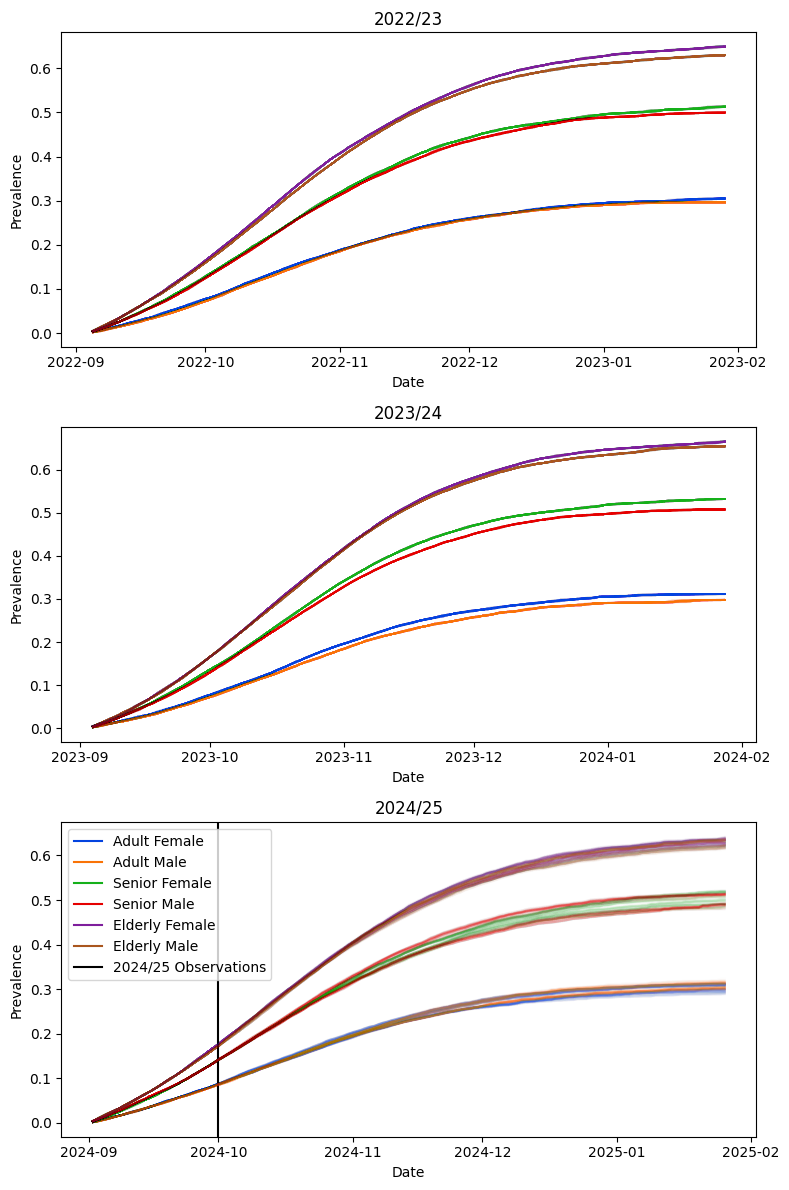

In [43]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")

    if season_range.season == "2024/25":
        ax.axvline(
            x=date(2024, 10, 1),
            color="black",
            linestyle="-",
            label="2024/25 Partial Observations",
        )

    custom_legend_elements = []
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            for row in chains_and_draws.itertuples():
                posterior_subset = partial_posterior_df_with_index.query(
                    f"chain == {row.chain} and draw == {row.draw} "
                    f"and season == '{season_range.season}' "
                    f"and sex == '{sex_category}' and age == '{age_category}'",
                ).copy()
                if row.chain == 0 and row.draw == 0:
                    custom_legend_elements.append(
                        (
                            Line2D([0], [0], color=color),
                            f"{age_category.title()} {sex_category.title()}",
                        ),
                    )
                ax.plot(
                    posterior_subset["date"].tolist(),
                    posterior_subset["prevalence"].tolist(),
                    color=color,
                    linestyle="-",
                    alpha=0.01,
                )

    if season_range.season == "2024/25":
        custom_legend_elements.append(
            (
                Line2D([0], [0], color="black", linestyle="-"),
                "2024/25 Observations",
            ),
        )
        custom_lines = [line[0] for line in custom_legend_elements]
        labels = [line[1] for line in custom_legend_elements]
        ax.legend(custom_lines, labels)

fig.tight_layout()
plt.show()

In [44]:
range_days_to_freq = {
    6: "W",
}
if range_days > 0:
    if (freq := range_days_to_freq.get(range_days)) is None:
        msg = (
            f"Range days {range_days} not supported, "
            f"please add to `range_days_to_freq` dictionary."
        )
        raise RuntimeError(msg)
    partial_incidence_posterior_df = (
        partial_posterior_df.groupby(
            [
                "chain",
                "draw",
                "season",
                pd.Grouper(key="date", freq=freq),
                "sex",
                "age",
            ],
        )["incidence"]
        .sum()
        .reset_index()
    )
partial_incidence_posterior_df = (
    partial_incidence_posterior_df if range_days > 0 else partial_posterior_df
).rename(columns={"date": "end_date"})
partial_incidence_posterior_df["start_date"] = partial_incidence_posterior_df[
    "end_date"
] - pd.Timedelta(days=range_days)
partial_incidence_posterior_df = (
    partial_incidence_posterior_df.groupby(
        ["season", "start_date", "end_date", "sex", "age"],
    )["incidence"]
    .agg(
        [
            lambda x: np.quantile(x, conf_lower),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, conf_higher),
        ],
    )
    .reset_index()
)
partial_incidence_posterior_df = partial_incidence_posterior_df.rename(
    columns={
        partial_incidence_posterior_df.columns[-3]: "lower",
        partial_incidence_posterior_df.columns[-2]: "median",
        partial_incidence_posterior_df.columns[-1]: "upper",
    },
)
partial_incidence_posterior_df

season start_date   end_date     sex      age     lower    median  \
0    2022/23 2022-09-05 2022-09-11  female    adult  0.016353  0.016364   
1    2022/23 2022-09-05 2022-09-11  female  elderly  0.033803  0.033812   
2    2022/23 2022-09-05 2022-09-11  female   senior  0.025344  0.025353   
3    2022/23 2022-09-05 2022-09-11    male    adult  0.014325  0.014336   
4    2022/23 2022-09-05 2022-09-11    male  elderly  0.033217  0.033227   
..       ...        ...        ...     ...      ...       ...       ...   
373  2024/25 2025-01-20 2025-01-26  female  elderly  0.001289  0.002733   
374  2024/25 2025-01-20 2025-01-26  female   senior  0.001185  0.003138   
375  2024/25 2025-01-20 2025-01-26    male    adult  0.000178  0.001350   
376  2024/25 2025-01-20 2025-01-26    male  elderly  0.001430  0.003184   
377  2024/25 2025-01-20 2025-01-26    male   senior  0.000816  0.002476   

        upper  
0    0.016373  
1    0.033822  
2    0.025363  
3    0.014345  
4    0.033237  
..        ...  
373  0.005667  
374  0.006241  
375  0.005678  
376  0.007369  
377  0.006598  

[378 rows x 8 columns]

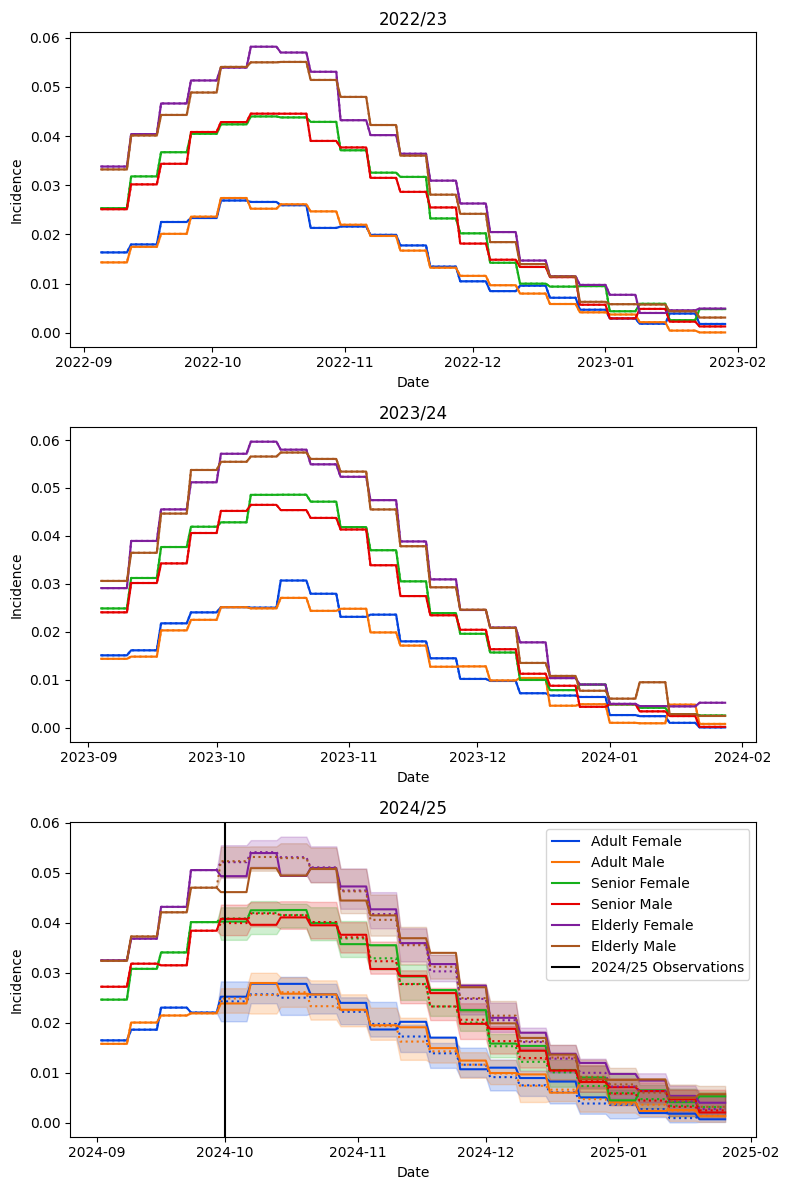

In [45]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = partial_incidence_posterior_df[
                (partial_incidence_posterior_df["season"] == season_range.season)
                & (partial_incidence_posterior_df["age"] == age_category)
                & (partial_incidence_posterior_df["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    summary_posterior_subset["start_date"].tolist(),
                    summary_posterior_subset["end_date"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    summary_posterior_subset["median"].tolist(),
                    summary_posterior_subset["median"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.plot(x, y, color=color, linestyle=":")

            y1 = [
                el
                for pair in zip(
                    summary_posterior_subset["lower"].tolist(),
                    summary_posterior_subset["lower"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y2 = [
                el
                for pair in zip(
                    summary_posterior_subset["upper"].tolist(),
                    summary_posterior_subset["upper"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)

    if season_range.season == "2024/25":
        ax.axvline(
            x=date(2024, 10, 1),
            color="black",
            linestyle="-",
            label="2024/25 Observations",
        )
        ax.legend()

fig.tight_layout()
plt.show()

In [46]:
partial_prevalence_posterior_df = (
    partial_posterior_df.groupby(["season", "date", "sex", "age"])["prevalence"]
    .agg(
        [
            lambda x: np.quantile(x, conf_lower),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, conf_higher),
        ],
    )
    .reset_index()
)
partial_prevalence_posterior_df = partial_prevalence_posterior_df.rename(
    columns={
        partial_prevalence_posterior_df.columns[-3]: "lower",
        partial_prevalence_posterior_df.columns[-2]: "median",
        partial_prevalence_posterior_df.columns[-1]: "upper",
    },
)
partial_prevalence_posterior_df

season       date     sex      age     lower    median     upper
0     2022/23 2022-09-05  female    adult  0.001036  0.002451  0.003636
1     2022/23 2022-09-05  female  elderly  0.003903  0.004427  0.005083
2     2022/23 2022-09-05  female   senior  0.002679  0.003577  0.004644
3     2022/23 2022-09-05    male    adult  0.001278  0.001753  0.002763
4     2022/23 2022-09-05    male  elderly  0.003785  0.004471  0.005512
...       ...        ...     ...      ...       ...       ...       ...
2641  2024/25 2025-01-26  female  elderly  0.612391  0.633235  0.661030
2642  2024/25 2025-01-26  female   senior  0.479417  0.498497  0.517043
2643  2024/25 2025-01-26    male    adult  0.284428  0.303887  0.326677
2644  2024/25 2025-01-26    male  elderly  0.613262  0.627780  0.648600
2645  2024/25 2025-01-26    male   senior  0.482637  0.497965  0.516807

[2646 rows x 7 columns]

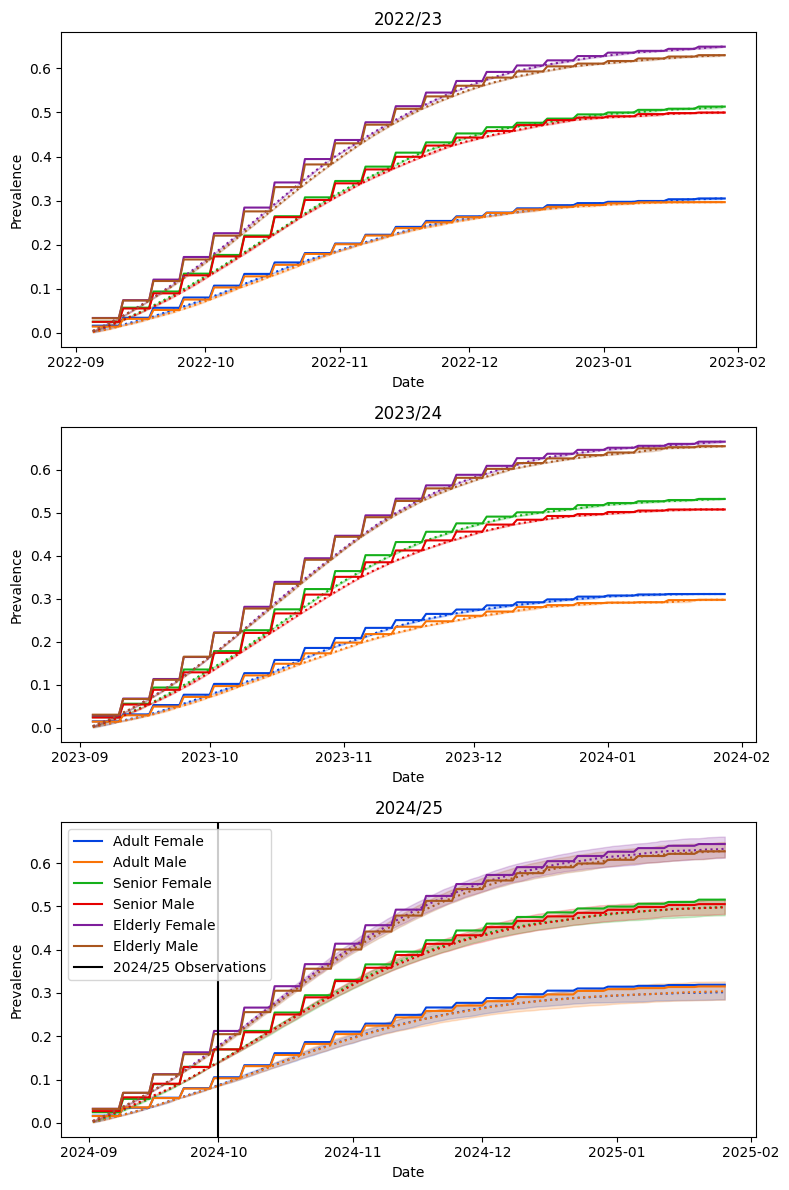

In [47]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                    strict=False,
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = partial_prevalence_posterior_df[
                (partial_prevalence_posterior_df["season"] == season_range.season)
                & (partial_prevalence_posterior_df["age"] == age_category)
                & (partial_prevalence_posterior_df["sex"] == sex_category)
            ]

            x = summary_posterior_subset["date"].tolist()
            y = summary_posterior_subset["median"].tolist()
            ax.plot(x, y, color=color, linestyle=":")

            y1 = summary_posterior_subset["lower"].tolist()
            y2 = summary_posterior_subset["upper"].tolist()
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)

    if season_range.season == "2024/25":
        ax.axvline(
            x=date(2024, 10, 1),
            color="black",
            linestyle="-",
            label="2024/25 Observations",
        )
        ax.legend()

fig.tight_layout()
plt.show()

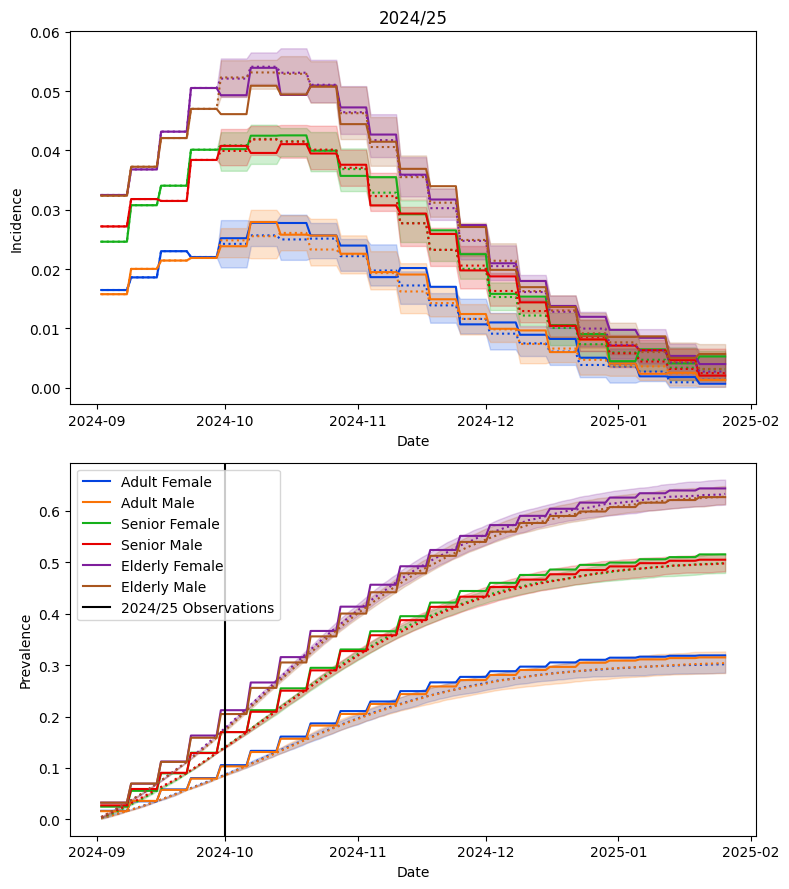

In [48]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 9),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors,
        product(age_cov.categories, sex_cov.categories),
        strict=False,
    )
}

ax = axes[0]
ax.set_title("2024/25")
ax.set_xlabel("Date")
ax.set_ylabel("Incidence")
for age_category in age_cov.categories:
    for sex_category in sex_cov.categories:
        color = colors_map[hash((age_category, sex_category))]
        observations_subset = observations[
            (observations["season"] == "2024/25")
            & (observations["age"] == age_category)
            & (observations["sex"] == sex_category)
        ]
        x = [
            el
            for pair in zip(
                observations_subset["start_date"].tolist(),
                observations_subset["end_date"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        y = [
            el
            for pair in zip(
                observations_subset["value"].tolist(),
                observations_subset["value"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        ax.plot(
            x,
            y,
            label=f"{age_category.title()} {sex_category.title()}",
            color=color,
            linestyle="-",
        )

        summary_posterior_subset = partial_incidence_posterior_df[
            (partial_incidence_posterior_df["season"] == season_range.season)
            & (partial_incidence_posterior_df["age"] == age_category)
            & (partial_incidence_posterior_df["sex"] == sex_category)
        ]
        x = [
            el
            for pair in zip(
                summary_posterior_subset["start_date"].tolist(),
                summary_posterior_subset["end_date"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        y = [
            el
            for pair in zip(
                summary_posterior_subset["median"].tolist(),
                summary_posterior_subset["median"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        ax.plot(x, y, color=color, linestyle=":")

        y1 = [
            el
            for pair in zip(
                summary_posterior_subset["lower"].tolist(),
                summary_posterior_subset["lower"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        y2 = [
            el
            for pair in zip(
                summary_posterior_subset["upper"].tolist(),
                summary_posterior_subset["upper"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        ax.fill_between(x, y1, y2, color=color, alpha=0.2)


ax = axes[1]
ax.set_xlabel("Date")
ax.set_ylabel("Prevalence")
for age_category in age_cov.categories:
    for sex_category in sex_cov.categories:
        color = colors_map[hash((age_category, sex_category))]
        observations_subset = observations_prevalence[
            (observations_prevalence["season"] == season_range.season)
            & (observations_prevalence["age"] == age_category)
            & (observations_prevalence["sex"] == sex_category)
        ]
        x = [
            el
            for pair in zip(
                observations_subset["start_date"].tolist(),
                observations_subset["end_date"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        y = [
            el
            for pair in zip(
                observations_subset["prevalence"].tolist(),
                observations_subset["prevalence"].tolist(),
                strict=False,
            )
            for el in pair
        ]
        ax.plot(
            x,
            y,
            label=f"{age_category.title()} {sex_category.title()}",
            color=color,
            linestyle="-",
        )

        summary_posterior_subset = partial_prevalence_posterior_df[
            (partial_prevalence_posterior_df["season"] == season_range.season)
            & (partial_prevalence_posterior_df["age"] == age_category)
            & (partial_prevalence_posterior_df["sex"] == sex_category)
        ]

        x = summary_posterior_subset["date"].tolist()
        y = summary_posterior_subset["median"].tolist()
        ax.plot(x, y, color=color, linestyle=":")

        y1 = summary_posterior_subset["lower"].tolist()
        y2 = summary_posterior_subset["upper"].tolist()
        ax.fill_between(x, y1, y2, color=color, alpha=0.2)

ax.axvline(
    x=date(2024, 10, 1),
    color="black",
    linestyle="-",
    label="2024/25 Observations",
)
ax.legend()


fig.tight_layout()
plt.show()